# 7. Деревья решений и случайный лес. Практика

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики

from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import preprocessing #предобработка
%matplotlib inline

In [2]:
# Итак, прочитаем нашу таблицу:
churn_data = pd.read_csv('data/churn.csv')

# Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:
churn_data = churn_data[churn_data['Geography'] == 'Germany']

# Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

# Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:
#  BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
#  TenureByAge — отношение времени пользования банком к возрасту клиента;
#  CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/churn_data['Age']

# Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [6]:
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#### 7.1

In [7]:
#Создаём объект класса DecisionTreeClassifier
dtc = tree.DecisionTreeClassifier(
    max_depth=8, #максимальная глубина дерева
    criterion='entropy', #критерий эффективности
    min_samples_leaf = 10, #Минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
dtc.fit(X_train, y_train)
 
#Делаем предсказание класса
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

#Выводим отчёт о метриках
print(round(metrics.f1_score(y_train, y_pred_train),2))
print(round(metrics.f1_score(y_test, y_pred_test),2))

0.73
0.64


#### 7.2

In [9]:
#Создаём объект класса RandomForestClassifier
rfc = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    max_depth=8, #максимальная глубина дерева
    criterion='entropy', #критерий эффективности
    min_samples_leaf = 10, #Минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rfc.fit(X_train, y_train)
 
#Делаем предсказание класса
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

#Выводим отчёт о метриках
print(round(metrics.f1_score(y_train, y_pred_train),2))
print(round(metrics.f1_score(y_test, y_pred_test),2))

0.73
0.65


#### 7.4

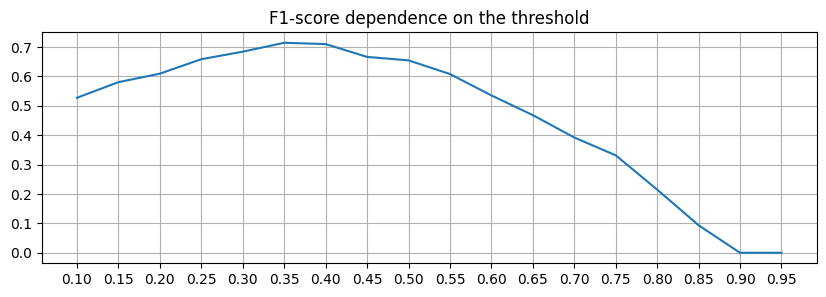

In [11]:
y_test_proba_pred = pd.Series(rfc.predict_proba(X_test)[:, 1])
f1_scores = []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(thresholds, f1_scores, label='F1')
ax.set_title('F1-score dependence on the threshold')
ax.set_xticks(thresholds) 
ax.grid();

#### 7.5

In [12]:
threshold_opt = 0.35
y_test_pred_opt  = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print(round(metrics.f1_score(y_test, y_test_pred_opt),2))

0.71
